### **ARIMA MODEL**

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings


# **load data**


In [27]:
matches_path="/content/matches.csv"
matches_df=pd.read_csv(matches_path)
print(matches_df.shape)

matches_df.head(5)
#data preparation
matches_df['date'] = pd.to_datetime(matches_df['date'])
matches_df.head(5)


(1095, 20)


,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan


In [28]:
deliverie_path="/content/deliveries.csv"
deliverie=pd.read_csv(deliverie_path)
deliverie.head(5)

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN


In [29]:
#reshape and caluclate team metrics
team_performance=matches_df.melt(
    id_vars=["id","season","date","winner","result_margin","result","target_runs"],
    value_vars=["team1","team2"],
    var_name="home_away",
    value_name="team"
)
team_performance["is_winner"]=(team_performance["team"]==team_performance["winner"]).astype(int)
team_performance["runs_scored"]=team_performance["target_runs"]
team_performance["runs_conceded"]=team_performance.groupby("id")["target_runs"].transform("sum")-team_performance["target_runs"]
team_performance.head(5)

,id,season,date,winner,result_margin,result,target_runs,home_away,team,is_winner,runs_scored,runs_conceded
0,335982,2007/08,2008-04-18,Kolkata Knight Riders,140.0,runs,223.0,team1,Royal Challengers Bangalore,0,223.0,223.0
1,335983,2007/08,2008-04-19,Chennai Super Kings,33.0,runs,241.0,team1,Kings XI Punjab,0,241.0,241.0
2,335984,2007/08,2008-04-19,Delhi Daredevils,9.0,wickets,130.0,team1,Delhi Daredevils,1,130.0,130.0
3,335985,2007/08,2008-04-20,Royal Challengers Bangalore,5.0,wickets,166.0,team1,Mumbai Indians,0,166.0,166.0
4,335986,2007/08,2008-04-20,Kolkata Knight Riders,5.0,wickets,111.0,team1,Kolkata Knight Riders,1,111.0,111.0


## **Aggregate the data for batsman**

In [30]:
#aggreated data for each team
team_performance_agg =team_performance.groupby(["team" ,"date"]).agg({
    "is_winner":"sum",
    "runs_scored":"sum",
    "runs_conceded":"sum"
}).sort_values("date").reset_index()

team_performance_agg["net_run_rate"] =team_performance_agg["runs_scored"] - team_performance_agg["runs_conceded"]
team_performance_agg

,team,date,is_winner,runs_scored,runs_conceded,net_run_rate
0,Royal Challengers Bangalore,2008-04-18,0,223.0,223.0,0.0
1,Kolkata Knight Riders,2008-04-18,1,223.0,223.0,0.0
2,Delhi Daredevils,2008-04-19,1,130.0,130.0,0.0
3,Rajasthan Royals,2008-04-19,0,130.0,130.0,0.0
4,Kings XI Punjab,2008-04-19,0,241.0,241.0,0.0
...,...,...,...,...,...,...
2185,Royal Challengers Bengaluru,2024-05-22,0,173.0,173.0,0.0
2186,Rajasthan Royals,2024-05-24,0,176.0,176.0,0.0
2187,Sunrisers Hyderabad,2024-05-24,1,176.0,176.0,0.0
2188,Kolkata Knight Riders,2024-05-26,1,114.0,114.0,0.0


In [31]:
team_name = "Chennai Super Kings"
team_data = team_performance_agg[team_performance_agg["team"] ==team_name]
team_data

,team,date,is_winner,runs_scored,runs_conceded,net_run_rate
5,Chennai Super Kings,2008-04-19,1,241.0,241.0,0.0
15,Chennai Super Kings,2008-04-23,1,209.0,209.0,0.0
20,Chennai Super Kings,2008-04-26,1,148.0,148.0,0.0
29,Chennai Super Kings,2008-04-28,1,179.0,179.0,0.0
39,Chennai Super Kings,2008-05-02,0,170.0,170.0,0.0
...,...,...,...,...,...,...
2145,Chennai Super Kings,2024-05-01,0,163.0,163.0,0.0
2153,Chennai Super Kings,2024-05-05,1,168.0,168.0,0.0
2164,Chennai Super Kings,2024-05-10,0,232.0,232.0,0.0
2168,Chennai Super Kings,2024-05-12,1,142.0,142.0,0.0


In [ ]:
team_data = team_data.sort_values("date")

team_data.set_index("date",inplace=True)
team_data

,team,is_winner,runs_scored,runs_conceded,net_run_rate
date,,,,,
2008-04-19,Chennai Super Kings,1,241.0,241.0,0.0
2008-04-23,Chennai Super Kings,1,209.0,209.0,0.0
2008-04-26,Chennai Super Kings,1,148.0,148.0,0.0
2008-04-28,Chennai Super Kings,1,179.0,179.0,0.0
2008-05-02,Chennai Super Kings,0,170.0,170.0,0.0
...,...,...,...,...,...
2024-05-01,Chennai Super Kings,0,163.0,163.0,0.0
2024-05-05,Chennai Super Kings,1,168.0,168.0,0.0
2024-05-10,Chennai Super Kings,0,232.0,232.0,0.0


In [32]:
# Select the column to predict (runs scored)
time_series = team_data['runs_scored']

# Stationarity Check (ADF Test)
adf_result = adfuller(time_series)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] > 0.05:
    print("The series is not stationary. Differencing is required.")


ADF Statistic: -15.403911052345627
p-value: 3.1883231923544007e-28


In [33]:
if adf_result[1] >0.05:
  time_series_diff = time_series.diff().dropna()
else:
  time_series_diff = time_series


In [34]:
train_size  = int(len(time_series_diff)*0.8)

train ,test = time_series_diff[:train_size] , time_series_diff[train_size:]

In [35]:
model = ARIMA(train , order =(1,1,1))
fitted_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


## **Forecast model**

In [36]:
forecast  = fitted_model.forecast(steps =len(test))
forecast.index =test.index
forecast.head(5)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,predicted_mean
1730,164.212317
1738,163.823465
1745,163.817601
1750,163.817513
1752,163.817512


## **LOSS FUNCTIONS**

In [37]:
import numpy as np
actual_runs = test.values
forecast_runs = forecast.values

mae = np.mean(np.abs(actual_runs - forecast_runs))
print(f"Mean Absolute Error (MAE): ",mae )
rmse  = np.sqrt(np.mean((actual_runs - forecast_runs)**2))
print(f"Root Mean Squared Error (RMSE): ",rmse )


Mean Absolute Error (MAE):  31.694176709444605
Root Mean Squared Error (RMSE):  42.04032771610818


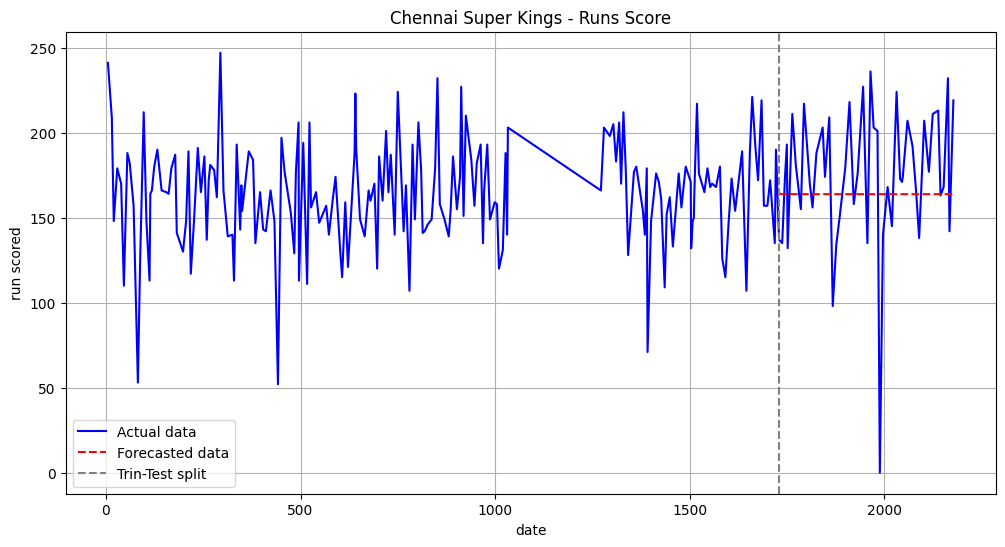

In [38]:
plt.figure(figsize = (12, 6))
plt.plot(time_series_diff , label ="Actual data" , color ="blue")
plt.plot(forecast ,label ="Forecasted data" , color="red", linestyle ="--")
plt.axvline(x =test.index[0], color="gray", linestyle = "--",label = "Trin-Test split")
plt.title(f"{team_name} - Runs Score")
plt.xlabel("date")
plt.ylabel("run scored")
plt.legend()
plt.grid()
plt.show()


In [46]:
# Filter data for the specific player
dhoni_scores = deliverie[deliverie['batter'] == 'MS Dhoni']

# Group data by match and summarize
dhoni_scores = dhoni_scores.groupby('match_id')['batsman_runs'].sum().reset_index()

# Compute total runs scored by the player
total_runs = dhoni_scores['batsman_runs'].sum()

# Select subset of matches
dhoni_scores = dhoni_scores.head(240)

# Prepare data for ARIMA
dhoni_scores['match_number'] = range(1, len(dhoni_scores) + 1)
dhoni_scores.set_index('match_number', inplace=True)

# Fit the ARIMA model
model = ARIMA(dhoni_scores['batsman_runs'], order=(1, 1, 1))
model_fit = model.fit()

# Forecast future matches
forecast_steps = 5
forecast = model_fit.forecast(steps=forecast_steps)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

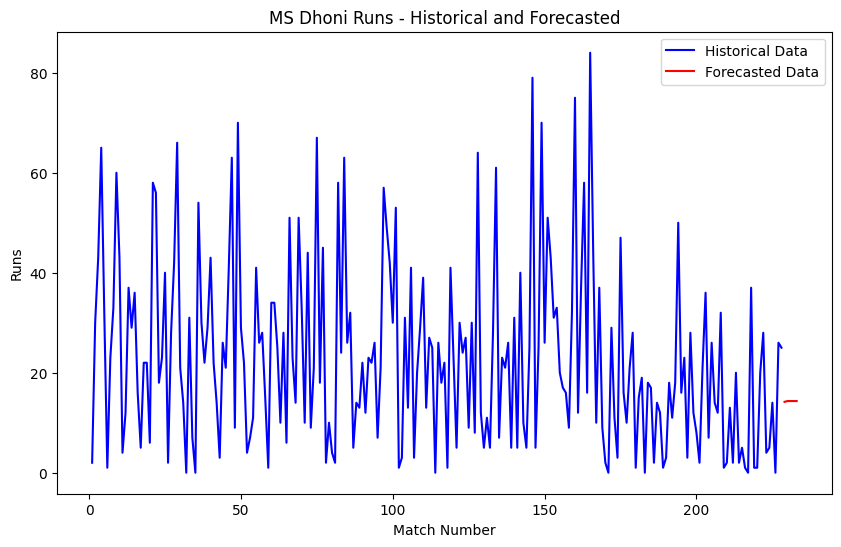

228    14.177092
229    14.334177
230    14.331897
231    14.331930
232    14.331929
Name: predicted_mean, dtype: float64


In [47]:
# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(dhoni_scores['batsman_runs'], label='Historical Data', color='blue')
plt.plot(range(len(dhoni_scores) + 1, len(dhoni_scores) + 1 + forecast_steps),
         forecast, label='Forecasted Data', color='red')
plt.title('MS Dhoni Runs - Historical and Forecasted')
plt.xlabel('Match Number')
plt.ylabel('Runs')
plt.legend()
plt.show()

# Print forecasted values
print(forecast)

In [49]:
# Calculate total runs scored by each batter
batter_scores = deliverie.groupby('batter')['batsman_runs'].sum().reset_index()
batter_scores = batter_scores.sort_values(by='batsman_runs', ascending=False).head(5)

# Iterate through the top 5 batters
forecasts = {}
for batter in batter_scores['batter']:
    # Filter data for the specific player
    player_scores = deliverie[deliverie['batter'] == batter]

    # Group data by match and summarize
    player_scores = player_scores.groupby('match_id')['batsman_runs'].sum().reset_index()

    # Select subset of matches
    player_scores = player_scores.head(240)

    # Prepare data for ARIMA
    player_scores['match_number'] = range(1, len(player_scores) + 1)
    player_scores.set_index('match_number', inplace=True)

    # Fit the ARIMA model
    model = ARIMA(player_scores['batsman_runs'], order=(1, 1, 1))
    model_fit = model.fit()

    # Forecast future matches
    forecast_steps = 5
    forecast = model_fit.forecast(steps=forecast_steps)
    forecasts[batter] = forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

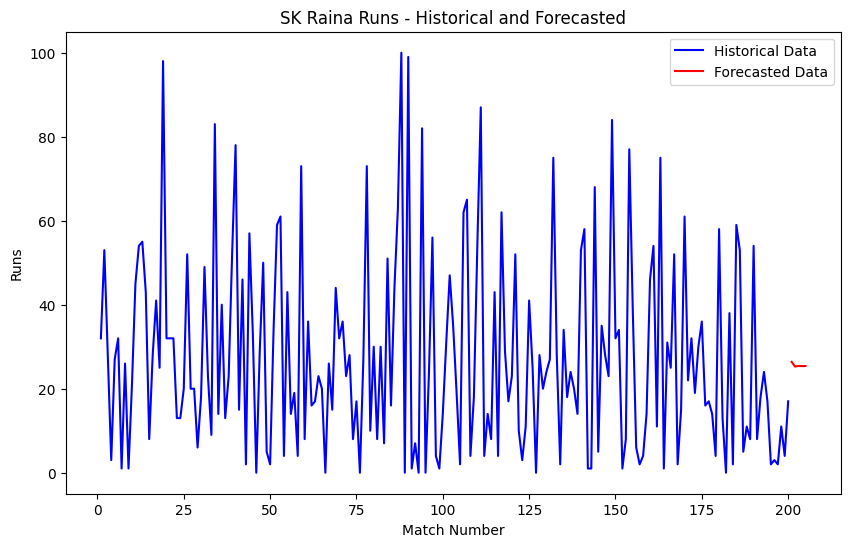

Forecast for SK Raina:
200    26.396030
201    25.281171
202    25.413451
203    25.397756
204    25.399618
Name: predicted_mean, dtype: float64


In [51]:
# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(player_scores['batsman_runs'], label='Historical Data', color='blue')
plt.plot(range(len(player_scores) + 1, len(player_scores) + 1 + forecast_steps),
             forecast, label='Forecasted Data', color='red')
plt.title(f'{batter} Runs - Historical and Forecasted')
plt.xlabel('Match Number')
plt.ylabel('Runs')
plt.legend()
plt.show()

    # Print forecasted values for the player
print(f"Forecast for {batter}:")
print(forecast)


## **Time Series Analysis of Bowlers**

In [58]:
bowler_stats = deliverie.groupby(['match_id', 'bowler']).agg(
    total_wickets=('is_wicket', 'sum'),
    total_runs=('total_runs', 'sum')
).reset_index()
bowler_stats

,match_id,bowler,total_wickets,total_runs
0,335982,AA Noffke,1,41
1,335982,AB Agarkar,3,25
2,335982,AB Dinda,2,9
3,335982,CL White,0,24
4,335982,I Sharma,1,13
...,...,...,...,...
12973,1426312,PJ Cummins,1,18
12974,1426312,SP Narine,1,20
12975,1426312,Shahbaz Ahmed,1,28
12976,1426312,T Natarajan,0,29


In [59]:
bowler_performance = bowler_stats.groupby('bowler').agg(
    total_wickets=('total_wickets', 'sum'),
    total_runs=('total_runs', 'sum'),
    matches_played=('match_id', 'count')
).reset_index()
bowler_performance['economy_rate'] = bowler_performance['total_runs'] / (bowler_performance['matches_played'] * 6)
bowler_performance['wickets_per_match'] = bowler_performance['total_wickets'] / bowler_performance['matches_played']

# **Time Series Analysis of best bowler**

In [60]:
top_bowlers = bowler_performance.sort_values(by='total_wickets', ascending=False).head(1)
selected_bowler = top_bowlers.iloc[0]['bowler']

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

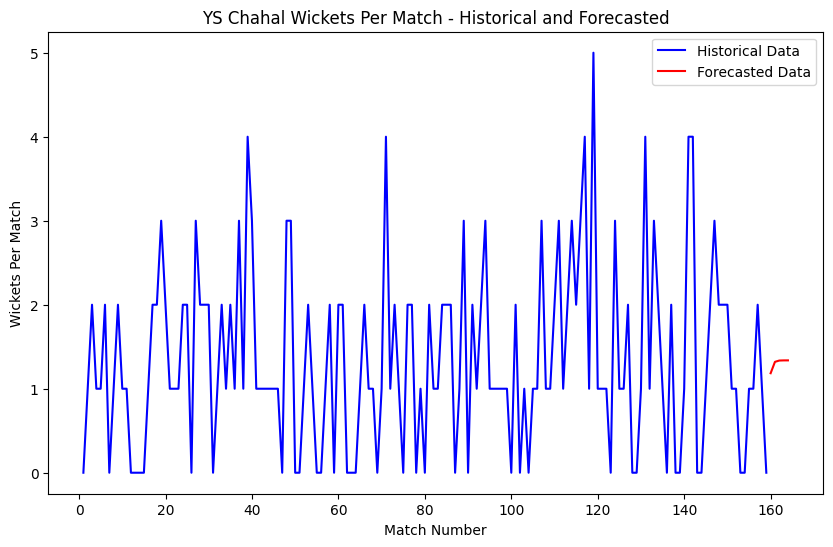

Forecast for YS Chahal:
159    1.184572
160    1.319978
161    1.335456
162    1.337225
163    1.337428
Name: predicted_mean, dtype: float64


In [62]:
selected_bowler_stats = bowler_stats[bowler_stats['bowler'] == selected_bowler]

selected_bowler_stats = selected_bowler_stats.groupby('match_id').agg(
    wickets_per_match=('total_wickets', 'sum')
).reset_index()
selected_bowler_stats['match_number'] = range(1, len(selected_bowler_stats) + 1)
selected_bowler_stats.set_index('match_number', inplace=True)

# Fit the ARIMA model
model = ARIMA(selected_bowler_stats['wickets_per_match'], order=(1, 1, 1))
model_fit = model.fit()

# Forecasting
forecast_steps = 5
forecast = model_fit.forecast(steps=forecast_steps)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(selected_bowler_stats['wickets_per_match'], label='Historical Data', color='blue')
plt.plot(range(len(selected_bowler_stats) + 1, len(selected_bowler_stats) + 1 + forecast_steps),
         forecast, label='Forecasted Data', color='red')
plt.title(f'{selected_bowler} Wickets Per Match - Historical and Forecasted')
plt.xlabel('Match Number')
plt.ylabel('Wickets Per Match')
plt.legend()
plt.show()
# Print forecasted values
print(f"Forecast for {selected_bowler}:")
print(forecast)

## **Time Series Analysis of Top 5 Bowlers**

In [63]:
top_bowlers = bowler_performance.sort_values(by='total_wickets', ascending=False).head(5)
top_bowlers

,bowler,total_wickets,total_runs,matches_played,economy_rate,wickets_per_match
524,YS Chahal,213,4681,159,4.906709,1.339623
119,DJ Bravo,207,4436,158,4.679325,1.310127
348,PP Chawla,201,5179,191,4.519197,1.052356
446,SP Narine,200,4672,175,4.449524,1.142857
355,R Ashwin,198,5435,208,4.354968,0.951923


<Axes: xlabel='bowler', ylabel='total_wickets'>

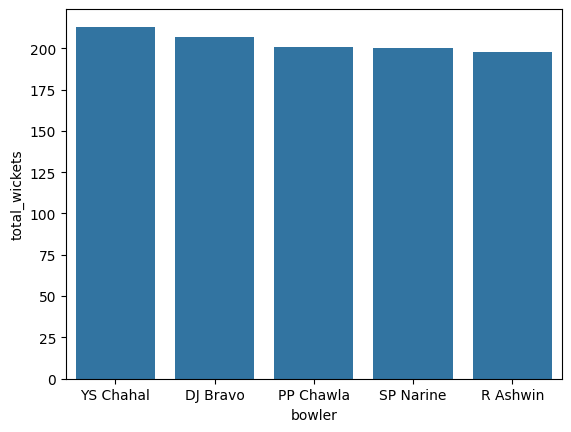

In [64]:

import seaborn as sns
sns.barplot(x='bowler',y='total_wickets',data=top_bowlers)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

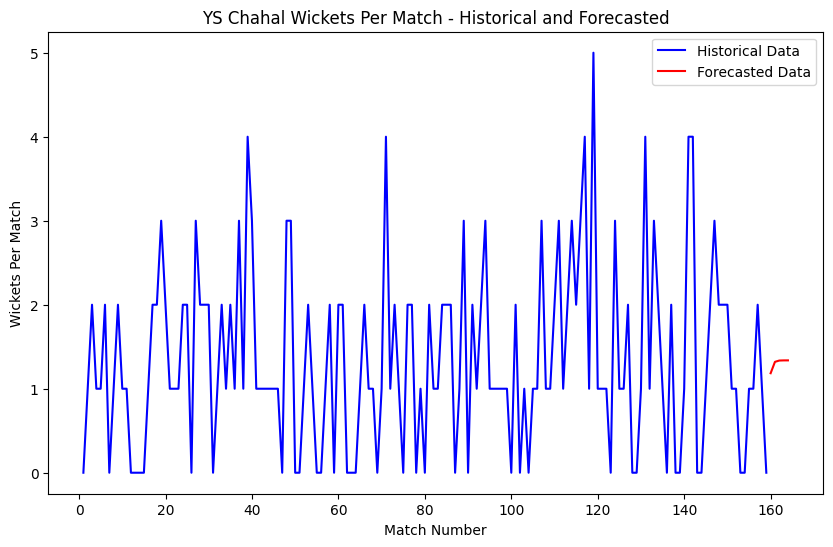

Forecast for YS Chahal:
159    1.184572
160    1.319978
161    1.335456
162    1.337225
163    1.337428
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

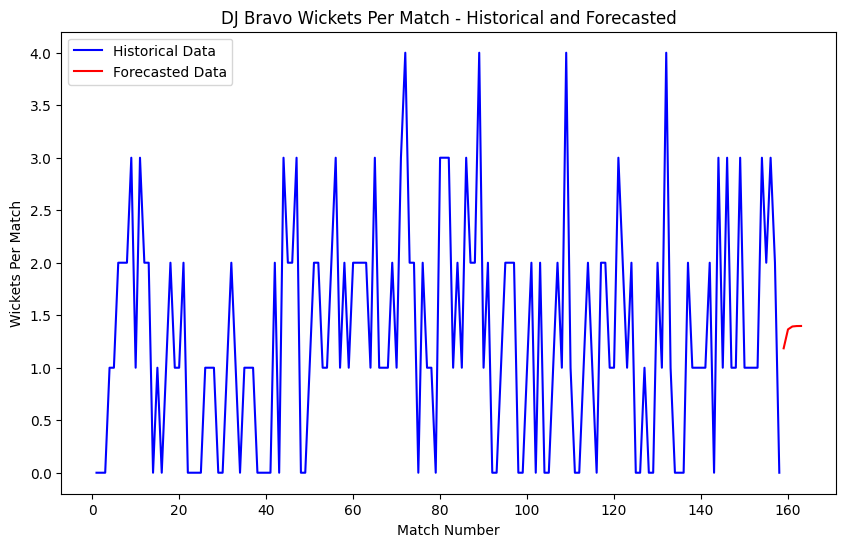

Forecast for DJ Bravo:
158    1.184908
159    1.365293
160    1.392754
161    1.396934
162    1.397571
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

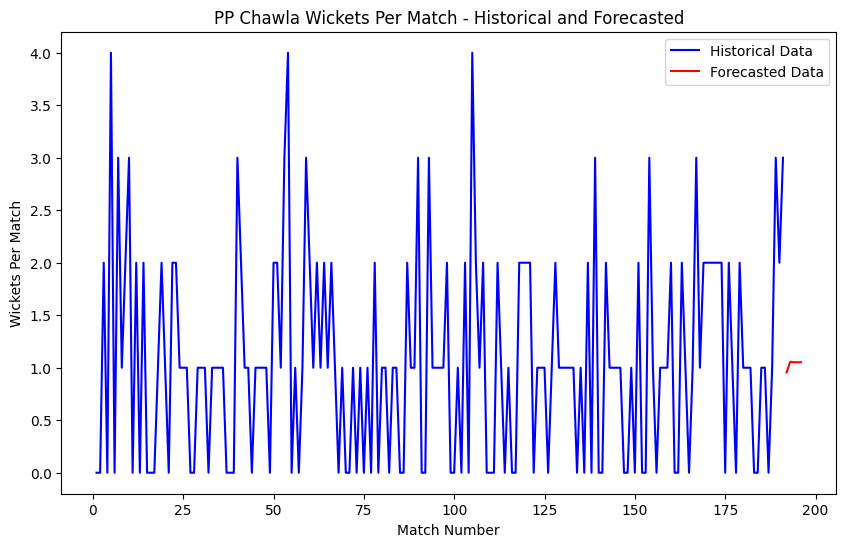

Forecast for PP Chawla:
191    0.955663
192    1.056916
193    1.051901
194    1.052150
195    1.052137
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

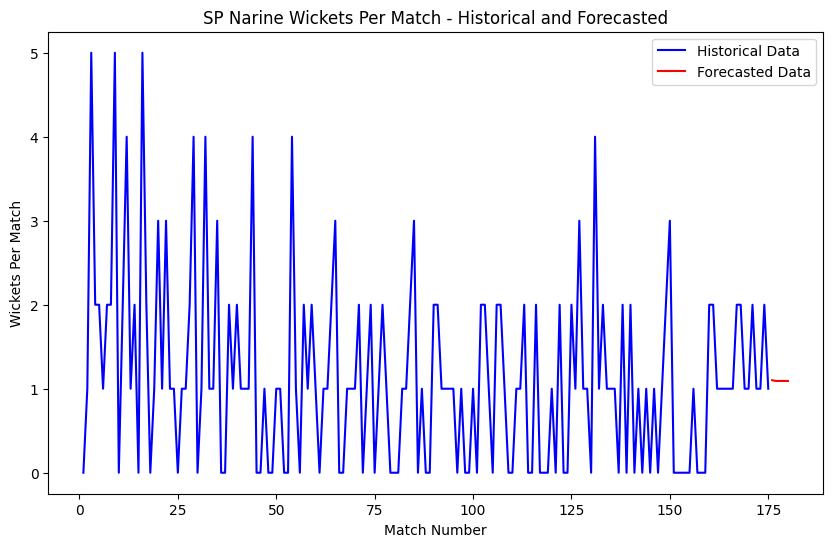

Forecast for SP Narine:
175    1.101303
176    1.091760
177    1.092659
178    1.092574
179    1.092582
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

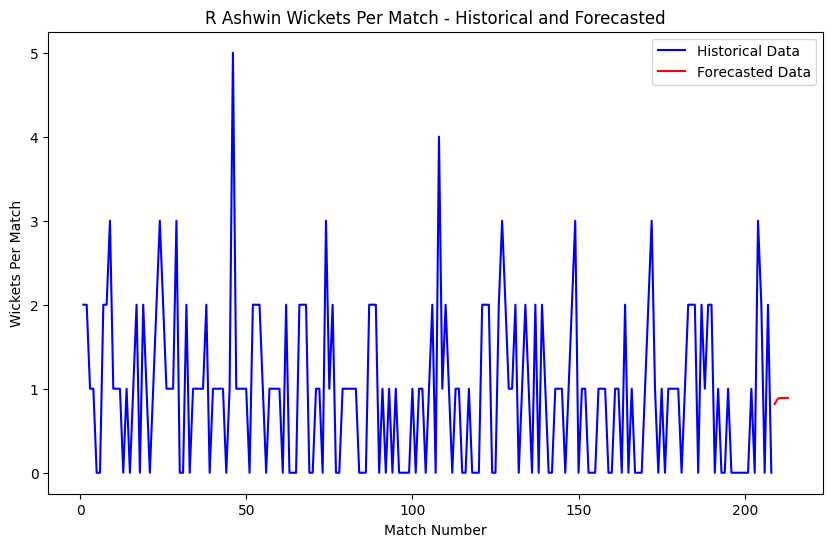

Forecast for R Ashwin:
208    0.817042
209    0.884181
210    0.889698
211    0.890152
212    0.890189
Name: predicted_mean, dtype: float64


In [65]:
forecasts = {}
for bowler in top_bowlers['bowler']:
    selected_bowler_stats = bowler_stats[bowler_stats['bowler'] == bowler]

    selected_bowler_stats = selected_bowler_stats.groupby('match_id').agg(
        wickets_per_match=('total_wickets', 'sum')
    ).reset_index()
    selected_bowler_stats['match_number'] = range(1, len(selected_bowler_stats) + 1)
    selected_bowler_stats.set_index('match_number', inplace=True)

    # Fit the ARIMA model
    model = ARIMA(selected_bowler_stats['wickets_per_match'], order=(1, 1, 1))
    model_fit = model.fit()

    # Forecasting
    forecast_steps = 5
    forecast = model_fit.forecast(steps=forecast_steps)
    forecasts[bowler] = forecast

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(selected_bowler_stats['wickets_per_match'], label='Historical Data', color='blue')
    plt.plot(range(len(selected_bowler_stats) + 1, len(selected_bowler_stats) + 1 + forecast_steps),
             forecast, label='Forecasted Data', color='red')
    plt.title(f'{bowler} Wickets Per Match - Historical and Forecasted')
    plt.xlabel('Match Number')
    plt.ylabel('Wickets Per Match')
    plt.legend()
    plt.show()

    # Print forecasted values for the bowler
    print(f"Forecast for {bowler}:")
    print(forecast)